# Lab Audio/ Music Auto-Tagging multi-label

**WARNING: This jupiter notebook was created as part of Télécom-Paris teaching programme and is distributed only to its students. 
Any re-use, modification, distribution outside this framework or making it available (through github, colab or others) is forbidden.**

- Date: 2022/02/07
- Version: v0.1
- Author: geoffroy.peeters@telecom-paris.fr

## Objectives of this Lab:

[Magna-Tag-A-Tune](https://musicmachinery.com/2009/04/01/magnatagatune-a-new-research-data-set-for-mir/) is a dataset containing 25,863 music clips belonging to one of the 5223 songs, 445 albums and 230 artists. 
The clips span a broad range of genres like Classical, New Age, Electronica, Rock, Pop, World, Jazz, Blues, Metal, Punk, and more. 
Each audio clip has been annotated by humans playing the two-player online Tag-A-Tune game. 
The annotations include tags like ’singer’, ’no singer’, ’violin’, ’drums’, ’classical’, ’jazz’. 

From this large dataset, we extracted a smaller dataset (1000 music clips) corresponding to the annotation into **instrumentation**.
The labels of this dataset are highly unbalanced (some tags are much frequent than others).
In this lab, you will develop a system to perform the automatic estimation of these tags. Since tags can co-occur (they are not mutually exclusive), the problem is a **multi-label classification**.

## Dataset

This dataset is available as a .json file and a .zip file.
You will first upload both to your Google Drive in a folder named 'My Drive/_sound/_magnatagatune'.
You will first **mount your Google drive** in this notebook to allow accessing its storage.
For this lab, we will also run the code on the GPU of Google colab. Do not forget to set **execution type** to GPU.

## Feature extraction.
For each file, you will extract its audio representations/features using ```librosa```.
The representation we will use is the Log-Mel-Spectrogram (with 128 Mel bands), i.e. the Mel-Spectrogram in Log-scale. 
This representation is the standard inut representation for Deep Neural Network; it is close to the MFCC one but skipping the last DCT.
Note that we will use a $\log(1 + C x)$ with $C=10000$ instead of the standard $\log(x)$ function. This is to avoid over-representing very small values.

In order to avoid having to compute the audio representations/features each time we need them, we will store them as files in the Drive.

## Audio patches
We will then use a ConvNet to perform the classification of the file over time. 
For this the big matrix containing the audio representations./features is sliced over time as a succession of 2D patches.
These 2D patches are the inputs of our ```ConvNet```. 
A single file is therefore represented by a succession of 2D patches.

## Dataset and Dataloader 

Unlike scholar examples (using make_circle or MNIST) it is not possible to get all the data simultaneously in memory and then select the one needed for each mini-batch. Instead, we need to develop a ```generator```which will provide the data on-demand (get in memory only the data needed to process a mini-batch). We will do this using the very very convenient ```DataSet``` and ```DataLoader``` from pytorch.

## Deep Neural Network

We then train a ConvNet which takes as input the patches (by using the DataLoader) and return the probability of each tag. 

The network has as many outputs neurons as the number of tags.
Since we deal multi-label, neurons are independent of each others. 
We then use a sigmoid for each.
We minimize the sum of the Binary Cross Entropy (BCE) over neurons.
Note that in pytorch it is common to combine the sigmoid and the BCE into a new loss; here denoted ``BCEWithLogitsLoss``. 
In this case, the output of the network does not have any non-linear functions. 
In multi-label classification, for each class $c$, the number of negative examples $|y^{(i)}_c=0|$ is usually much larger than of positive examples $|y^{(i)}_c=1|$. It is therefore benefitial to give a higher weights to positive examples in ``BCEWithLogitsLoss``.

## Testing: tag-o-gram

Once train, we will apply our model to compute the tag-o-gram (likelihood of each tags over time) of an unknown file.



## At the end of this Lab, the student will be able to
- Use colab and connect it to Google Drive to work on/store remote data
- Process datasets directly from Colab
- Use librosa https://librosa.github.io/librosa/ to compute audio representations 
- Use DataSet and DataLoaders to get on the fly the necessary data for a batch
- Perform a multi-label task (tag an audio file into multi-labels) using a Deep Convolutional Neural Network in pytorch


In [40]:
import numpy as np
import matplotlib.pyplot as plt

import glob
import os
import shutil
import json

import IPython
from tqdm import tqdm
import warnings
warnings.filterwarnings(action='ignore')
import pprint as pp

import librosa

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

In [41]:
# If necessary, install ffmpeg to allows mp3 decoding
! pip install ffmpeg

# Parameters

In [42]:
use_colab = True
use_gpu = True

do_magnatagatune1_gtzan2  = 1

patch_hop_frame = 17
patch_halfduration_frame = 34
data_ext = '.lms'
do_norm = True

dropout_prob = 0.2
nb_epoch = 50
do_model_train = True

do_student = True

do_class_method = 'multilabel'
subDIR = '/_magnatagatune/'
dataset_json = 'dataset_magna-tag-a-tune-sub-instr-100.json'
dataset_zip = 'dataset_magna-tag-a-tune.zip'
dataset_subDIR =  '/dataset_magna-tag-a-tune/'
labelname_dict_l = ['guitar', 'string', 'synth', 'drum', 'violin', 'piano', 'female', 'male', 'sitar', 'flute', 'harpsichord', 'harp']

# Set Google Drive

When you store locally data in Colab; these data will be removed at the end of your session.
In order to able to store definitely your data, you can connect Colab to your Google Drive and then store the data on it. It is done in the following way.

In [43]:
from google.colab import drive
mnt_point = '/content/drive/'
drive.mount(mnt_point)
DIR = mnt_point + '/My Drive/_sound/' + subDIR

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


We now unzip the file containing the audio of the dataset.

In [44]:
if not os.path.isdir(DIR + '/dataset_magna-tag-a-tune'):
  #shutil.unpack_archive(DIR + dataset_zip, DIR) #Caused missing data when unzip.
  !unzip -u "/content/drive//My Drive/_sound//_magnatagatune/dataset_magna-tag-a-tune.zip" -d "/content/drive//My Drive/_sound//_magnatagatune/";
  print(len(glob.glob(DIR + dataset_subDIR + '*/*')))

# Load and prepare dataset

The dataset (relationships between audio files and tags) is described in a json file.
We load this file and convert the tags to a multi-hot-encoding.

In [45]:
with open(DIR + dataset_json, 'r') as f:
    dataset_l = json.load(f)

if do_class_method=='multilabel':
  # ---- Convert tag to index of class
  for data in dataset_l:
      data['target'] = np.zeros(len(labelname_dict_l))
      for tag in data['tag']:
          if tag in labelname_dict_l:
              data['target'][ labelname_dict_l.index(tag) ] = 1

### Test

You should get the following output.
```
len(dataset_l):  1000
labelname_dict_l:  ['guitar', 'string', 'synth', 'drum', 'violin', 'piano', 'female', 'male', 'sitar', 'flute', 'harpsichord', 'harp']
{'album': 'J.S. Bach Solo Cantatas',
 'artist': 'American Bach Soloists',
 'clip_id': 6,
 'mp3_path': 'f/american_bach_soloists-j_s__bach_solo_cantatas-01-bwv54__i_aria-146-175.mp3',
 'original_url': 'http://he3.magnatune.com/all/01--BWV54%20-%20I%20Aria--ABS.mp3',
 'segmentEnd': 175,
 'segmentStart': 146,
 'tag': ['classical',
         'violin',
         'string',
         'classical',
         'opera',
         'violin',
         'baroque'],
 'target': array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 'title': 'BWV54 - I Aria',
 'track_number': 1,
 'url': 'http://www.magnatune.com/artists/albums/abs-solocantatas/'}
````


In [46]:
print('len(dataset_l): ', len(dataset_l))
print('labelname_dict_l: ',  labelname_dict_l )
pp.pprint(dataset_l[1])  

len(dataset_l):  1000
labelname_dict_l:  ['guitar', 'string', 'synth', 'drum', 'violin', 'piano', 'female', 'male', 'sitar', 'flute', 'harpsichord', 'harp']
{'album': 'J.S. Bach Solo Cantatas',
 'artist': 'American Bach Soloists',
 'clip_id': 6,
 'mp3_path': 'f/american_bach_soloists-j_s__bach_solo_cantatas-01-bwv54__i_aria-146-175.mp3',
 'original_url': 'http://he3.magnatune.com/all/01--BWV54%20-%20I%20Aria--ABS.mp3',
 'segmentEnd': 175,
 'segmentStart': 146,
 'tag': ['classical',
         'violin',
         'string',
         'classical',
         'opera',
         'violin',
         'baroque'],
 'target': array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 'title': 'BWV54 - I Aria',
 'track_number': 1,
 'url': 'http://www.magnatune.com/artists/albums/abs-solocantatas/'}


# Audio features

We create here a function that, given an audio file as input, 
- load the audio file
- extract a given audio representation/ audio features
- store the results in the drive; we do so since if this only needs to be computed once. The second time we call this function on the same file, it will load the results from the drive instead of recomputing it.

We will use the ```librosa``` package for that.

In [47]:
def F_do_standardization(data_m):
    """
    description:
      perform feature standardization (mean, std) over frames
    inputs:
      - data_m (nb_dim, nb_frame)
    outputs:
      - data_m (nb_dim, nb_frame)
    """
    if do_student:
        # --- START CODE HERE
        mean_v = np.mean(data_m, axis=0)
        std_v = np.std(data_m, axis=0)
        data_m = data_m-mean_v
        data_m = data_m/std_v
        # --- STOP CODE HERE
          
    return data_m

In [48]:
def F_log(data_m, C = 10000):
  """
  description:
    replacement to log function (to avoid emphasazing very small values)
  """
  return np.log(1 + C*data_m)

In [57]:
def F_get_audio_features(audio_filename, data_ext=''):
    """
    description:
      compute Log-Mel-Sepctrogram audio features with n_mels=128, window length L_n = 2048, and hop-size STEP_n = 1024
    inputs:
      - audio_filename
      - data_ext
    outputs:
      - data_m (nb_dim, nb_frame): Log-Mel-Sepctrogram matrix
      - time_sec_v (nb_frame): corresponding time [in sec] of analysis windows
    """
    L_n = 2048
    STEP_n = 1024
    feature_filename = audio_filename + data_ext + '.npz'

    #if not os.path.isfile(feature_filename):
    if True:
        
        if do_student:
            # --- START CODE HERE
            audio_v, sr_hz = librosa.load(audio_filename)
            data_m = librosa.feature.melspectrogram(y=audio_v, sr=sr_hz, n_fft=L_n, hop_length=STEP_n)
            #data_m = F_do_standardization(data_m)
            data_m = F_log(data_m)
            #data_m = F_do_standardization(data_m)
            time_sec_v = np.arange(0, audio_v.shape[0], STEP_n)/sr_hz
            print(data_m.shape[1])
            print(time_sec_v.shape)
            # --- STOP CODE HERE

        np.savez(feature_filename, data_m=data_m, time_sec_v=time_sec_v)
    else:
        all = np.load(feature_filename)
        data_m = all['data_m']
        time_sec_v = all['time_sec_v']

    return data_m, time_sec_v

### Test

We test the extraction of audio features on a single audio file. You should get the following output.

```
shape: (128, 628), min: 0.0, max: 9.236710548400879
```

<img src="https://perso.telecom-paristech.fr/gpeeters/doc/Lab_DL_MagnaTagATune_01.png">


628
(628,)
shape: (128, 628), min: 0.0, max: 9.236710548400879


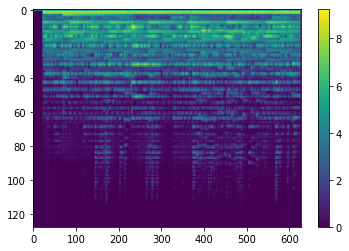

In [58]:
data_m, time_sec_v = F_get_audio_features(DIR + dataset_subDIR + dataset_l[900]['mp3_path'], data_ext);
plt.imshow(data_m, aspect='auto'); plt.colorbar()
print('shape: {}, min: {}, max: {}'.format(data_m.shape, np.min(data_m), np.max(data_m)))

In [59]:
np.mean(np.diff(time_sec_v))

0.046439909297052155

# Patches

When we deal with audio files, the audio representations/features is a matrix $W$ which represents the values of the representation/feature (such as spectrum, CQT, MFCC, Chroma, Log-Mel-gram) for each time frame of the audio file.

If the analysis is performed with a 20ms hop size, and the total duration of the file is 30s; we therefore have a 1500 vectors; each vector represent the audio representation/feature at a specific time.

The matrix $W$ has the size ```(nb_feature, nb_time_frame)```.

To process it with a Convolutional Neural Network, we will split this big matrix into a set of small matrices $A_m$ (we name those ```patches```) where each $A_m$ represent a temporal slice of the big-matrix. 
The size of $A_m$ will be ```(nb_feature, size_of_patch)```.
$W$ will then be represented by a set of $A_m$. 
Each $A_m$ has the same size but represent a slice of the big-matrix starting at a different time $t$.

The two parameters we need to define are:
- the distance in frames between two successive patch ```patch_hop_frame```
- the width of the patch ```patch_halfduration_frame```

Given an audio file, the following function compute the start and end position of each patch $A_m$ within $W$.

In [32]:
def F_slice_into_patches(patch_hop_frame, patch_halfduration_frame, patch_info_l, nb_frame, idx_file, label):
    """
    create structure for storing patch-based slides of the spectrogram
    """
    middle_frame = patch_halfduration_frame
    while middle_frame + patch_halfduration_frame < nb_frame:
        if do_student:
            # --- START CODE HERE
            start_frame = middle_frame - patch_halfduration_frame
            stop_frame = middle_frame + patch_halfduration_frame
            # --- STOP CODE HERE

        patch_info_d = {'idx_file': idx_file, 
                        'start_frame': start_frame, 
                        'middle_frame': middle_frame, 
                        'end_frame': stop_frame, 
                        'target': label}
        patch_info_l.append(patch_info_d)

        middle_frame += patch_hop_frame
    return patch_info_l

### Test

You should get the following output.

```
[{'end_frame': 64,
  'idx_file': 333,
  'middle_frame': 32,
  'start_frame': 0,
  'target': [1, 0, 0, 1, 0]},
 {'end_frame': 80,
  'idx_file': 333,
  'middle_frame': 48,
  'start_frame': 16,
  'target': [1, 0, 0, 1, 0]},
 {'end_frame': 96,
  'idx_file': 333,
  'middle_frame': 64,
  'start_frame': 32,
  'target': [1, 0, 0, 1, 0]}]
  ```

In [33]:
patch_info_l = F_slice_into_patches(patch_hop_frame=16, patch_halfduration_frame=32, patch_info_l=[], nb_frame=100, idx_file=333, label=[1,0,0, 1, 0])
pp.pprint(patch_info_l)

[{'end_frame': 64,
  'idx_file': 333,
  'middle_frame': 32,
  'start_frame': 0,
  'target': [1, 0, 0, 1, 0]},
 {'end_frame': 80,
  'idx_file': 333,
  'middle_frame': 48,
  'start_frame': 16,
  'target': [1, 0, 0, 1, 0]},
 {'end_frame': 96,
  'idx_file': 333,
  'middle_frame': 64,
  'start_frame': 32,
  'target': [1, 0, 0, 1, 0]}]


# Torch dataset
During the training of our network, we would like to have batches of data $x^{(i)}, y^{(i)}$ on the fly, without having to take care about where to read it from, how to format it and to check that all data have been processed before moving to the next epoch.

Pytorch provides a nice class for this: ``Dataset``.
This class has three mandatory methods:
- ``__init__``
- ``__len__``
- ``__getitem__``

Let's explain this from the end.
We instantiate the class using ``train_set = AudioDataSet(...)``.
We define one item of our dataset as one patch.
- Therefore ``len(train_set)`` should gives the number of patches of our dataset (which is the number of music tracks multiplied by the number of patches within a track). This is the goal of the ``__len__`` method.
- ``train_set[idx_patch]`` should give all the information for a given patch, i.e. $(x^{(i)}, y^{(i)}$ for this patch as well as the audio file and time position it is coming from. This is the goal of the ``__getitem__`` method.
- This means that ``__init__`` (the creator of the class) should store all the necessary information to allow ``__len__`` and ``__getitem__``.

Note that, in order to allow runing the model faster, we will store a part of the information directly on the GPU. We do so using ``.cuda()``.

We also add an option to the class to allow defining a dataset for the training and a dataset for the testing (here we do not split validation and testing).


In [34]:
class AudioDataSet(Dataset):
    """AudioDataSet Dataset
    Args:
        train (bool, optional)
        audio_filename_l: list of audio files
        labelname_l: list of label names
    Attributes:
        - audio_filename_l: list of audio files
        - labelname_dict_l: list of the terms used for the labels
        - patch_info_l: list of dictionaries containing patches information
            'idx_file': identifier of the file used for this patch (reference to audio_filename_l)
            'start_frame': starting frame of the patch in the audio file
            'middle_frame': middle frame of the patch in the audio file
            'end_frame': end frame of the patch in the audio file
            'target': identifier of the target used for this patch (reference to labelname_dict_l)
    """

    audio_filename_l = []
    labelname_dict_l = []
    patch_info_l = []
    data_d = {}

    def __init__(self, train, dataset_l, labelname_dict_l):
        """
        """
        
        self.labelname_dict_l = labelname_dict_l
        
        # --- split into train and test
        if train: dataset_l = [dataset_l[idx] for idx in range(len(dataset_l)) if idx % 10 != 0]
        else: dataset_l = [dataset_l[idx] for idx in range(len(dataset_l)) if idx % 10 == 0]
        
        self.audio_filename_l = [DIR + dataset_subDIR + data['mp3_path'] for data in dataset_l]
        
        self.patch_info_l = []
        self.data_d = {}
        
        if do_student:
            # --- START CODE HERE
            for idx_file in tqdm(range(len(self.audio_filename_l))):
                label = dataset_l[idx_file]['target']
                data_m, time_sec_v = F_get_audio_features(self.audio_filename_l[idx_file], "")
                nb_frame = data_m.shape[1]
                self.patch_info_l = F_slice_into_patches(patch_hop_frame, patch_halfduration_frame, self.patch_info_l, nb_frame, idx_file, label)
                self.data_d[self.audio_filename_l[idx_file]] = {'data_m': torch.from_numpy(data_m).float().cuda(), 'time_sec_v': time_sec_v}
            # --- STOP CODE HERE


    def __len__(self):
        """
        """
        return len(self.patch_info_l)



    def __getitem__(self, idx_patch):
        """
        return sample['idx_file','middle_frame','target','data']
        """
        audio_filename = self.audio_filename_l[ self.patch_info_l[idx_patch]['idx_file'] ]
        # --- Optimize: get directly from GPU
        data_m, time_sec_v = self.data_d[audio_filename]['data_m'], self.data_d[audio_filename]['time_sec_v']
        STEP_sec = np.mean(np.diff(time_sec_v))
        # --- get the patch
        data_m = data_m[:, self.patch_info_l[idx_patch]['start_frame']:self.patch_info_l[idx_patch]['end_frame']]
        
        # --- create output structure
        sample = {'idx_file': self.patch_info_l[idx_patch]['idx_file'],
                  'middle_frame': self.patch_info_l[idx_patch]['middle_frame'],
                  'target': self.patch_info_l[idx_patch]['target'],
                  'data': data_m,
                  'STEP_sec': STEP_sec
                  }
        return sample

Using this class, we instantiate a ``train_set`` and a ``test_set``.

In [37]:
print(dataset_l[0])

{'clip_id': 2, 'track_number': 1, 'title': 'BWV54 - I Aria', 'artist': 'American Bach Soloists', 'album': 'J.S. Bach Solo Cantatas', 'url': 'http://www.magnatune.com/artists/albums/abs-solocantatas/', 'segmentStart': 30, 'segmentEnd': 59, 'original_url': 'http://he3.magnatune.com/all/01--BWV54%20-%20I%20Aria--ABS.mp3', 'mp3_path': 'f/american_bach_soloists-j_s__bach_solo_cantatas-01-bwv54__i_aria-30-59.mp3', 'tag': ['classical', 'string', 'opera', 'violin'], 'target': array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])}


In [38]:
train_set = AudioDataSet(train=True, dataset_l=dataset_l, labelname_dict_l=labelname_dict_l)
test_set = AudioDataSet(train=False, dataset_l=dataset_l, labelname_dict_l=labelname_dict_l)

100%|██████████| 100/100 [01:43<00:00,  1.04s/it]


### Test

You should get the following output.

```
len(train_set):  31490
len(test_set):  3500
/content/drive//My Drive/_sound//_gtzan//dataset_gtzan//pop/pop.00065.wav
torch.Size([128, 68])
0.023219954648526078
duration of a patch in second: 1.5789569160997732
```

<img src="https://perso.telecom-paristech.fr/gpeeters/doc/Lab_DL_MagnaTagATune_02.png">

len(train_set):  29700
len(test_set):  3300
/content/drive//My Drive/_sound//_magnatagatune//dataset_magna-tag-a-tune/f/pain_factor-8_seconds-01-8_seconds-175-204.mp3
torch.Size([128, 68])
0.046439909297052155
duration of a patch in second: 3.1579138321995464


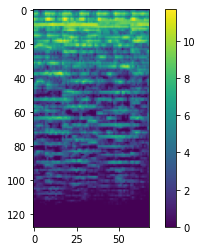

In [39]:
print('len(train_set): ', len(train_set))
print('len(test_set): ', len(test_set))

idx_file = 50
print(train_set.audio_filename_l[idx_file])
print(train_set[idx_file]['data'].size())
print(train_set[idx_file]['STEP_sec'])
plt.imshow(train_set[idx_file]['data'].cpu().numpy()); plt.colorbar();

print('duration of a patch in second:', train_set[idx_file]['STEP_sec']*train_set[idx_file]['data'].size(1))

# Torch dataloader

```DataLoader```is a **very very convenient** way pytorch to provide to load on the fly the data necessary for a given mini-batch. It will simply pick-up from our DataSets the data necessary for the given mini-batch. We do not need to care about counting them or shuffling them. It does everything for us.

In [60]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, num_workers=0)

### Test

You should get the following output.

```
torch.Size([32, 128, 68])
````


In [61]:
one_mini_batch = next(iter(train_loader))
one_mini_batch['data'].size()

torch.Size([32, 128, 68])

# DNN model

We now define the architecture of our Deep ConvNet to perform multi-label classification.
The network has the following architecture.

<img src="https://perso.telecom-paristech.fr/gpeeters/doc/Lab_DL_MagnaTagATune_03.png">

In [75]:
class DeepConvNet(torch.nn.Module):
    
    def __init__(self, n_in_H, nb_class):
        """
        inputs:
        - n_in_H: input dimension (128 in the case of Log-Mel-Gram)
        - nb_class: output dimension (number of tags to be estimated)
        """

        super(DeepConvNet, self).__init__()
        
        if do_student:
            # --- START CODE HERE
            #Layer 1
            self.layer1 = nn.Sequential(
                nn.Conv2d(1, 256, kernel_size = (n_in_H, 5)),
                nn.PReLU(1),
                nn.MaxPool2d((1,4)),
                nn.Dropout(0.2)
            )
            #Layer 2
            self.layer2 = nn.Sequential(
                nn.Conv2d(256, 256, kernel_size = (1, 5)),
                nn.PReLU(1),
                nn.MaxPool2d((1,2)),
                nn.Dropout(0.2)
            )
            #Layer 3
            self.layer3 = nn.Sequential(
                nn.Conv2d(256, 256, kernel_size = (1, 5)),
                nn.PReLU(1),
                nn.MaxPool2d((1,2)),
                nn.Dropout(0.2),
                nn.Flatten()
            )
            #Layer 4
            self.layer4 = nn.Sequential(
                nn.Linear(256, 256),
                nn.PReLU(1),
                nn.Dropout(0.2)
            )
            #Layer 5
            self.layer5 = nn.Sequential(
                nn.Linear(256, 256),
                nn.PReLU(1),
                nn.Dropout(0.2)
            )
            #classification
            self.layer6 = nn.Sequential(
                nn.Linear(256, nb_class)
            )
            # --- STOP CODE HERE

    def forward(self, x):
        if do_student:
            # --- START CODE HERE
            out = self.layer1(x)
            out = self.layer2(out)
            out = self.layer3(out)
            out = self.layer4(out)
            out = self.layer5(out)
            x = self.layer6(out)
            # --- STOP CODE HERE

  
        return x

### Test

We instantiate the model, send it to the GPU and display its summary.
You should get the following output.

```
n_in_H:  128
cuda:0
torch.Size([2, 1, 128, 68])
l1_conv:  torch.Size([2, 256, 1, 64])
l1_pool:  torch.Size([2, 256, 1, 16])
l2_conv:  torch.Size([2, 256, 1, 12])
l2_pool: torch.Size([2, 256, 1, 6])
l3_conv:  torch.Size([2, 256, 1, 2])
l3_conv:  torch.Size([2, 256, 1, 1])
l4_fc:  torch.Size([2, 256])
l5_fc:  torch.Size([2, 256])
l6_fc:  torch.Size([2, 12])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1           [-1, 256, 1, 64]         164,096
             PReLU-2           [-1, 256, 1, 64]               1
         MaxPool2d-3           [-1, 256, 1, 16]               0
           Dropout-4           [-1, 256, 1, 16]               0
            Conv2d-5           [-1, 256, 1, 12]         327,936
             PReLU-6           [-1, 256, 1, 12]               1
         MaxPool2d-7            [-1, 256, 1, 6]               0
           Dropout-8            [-1, 256, 1, 6]               0
            Conv2d-9            [-1, 256, 1, 2]         327,936
            PReLU-10            [-1, 256, 1, 2]               1
        MaxPool2d-11            [-1, 256, 1, 1]               0
          Dropout-12                  [-1, 256]               0
           Linear-13                  [-1, 256]          65,792
            PReLU-14                  [-1, 256]               1
          Dropout-15                  [-1, 256]               0
           Linear-16                  [-1, 256]          65,792
            PReLU-17                  [-1, 256]               1
          Dropout-18                  [-1, 256]               0
           Linear-19                   [-1, 12]           3,084
================================================================
Total params: 954,641
Trainable params: 954,641
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.41
Params size (MB): 3.64
Estimated Total Size (MB): 4.08
----------------------------------------------------------------
```

In [76]:
# --- Instantiate the model
one_mini_batch = next(iter(train_loader))
n_in_H = one_mini_batch['data'].size(1)
print('n_in_H: ', n_in_H)
model = DeepConvNet(n_in_H=n_in_H, nb_class=len(labelname_dict_l))

# --- Send the model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.cuda()

# --- Display the structure of the model
from torchsummary import summary
summary(model, input_size=(1, n_in_H, 68))

n_in_H:  128
cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 256, 1, 64]         164,096
             PReLU-2           [-1, 256, 1, 64]               1
         MaxPool2d-3           [-1, 256, 1, 16]               0
           Dropout-4           [-1, 256, 1, 16]               0
            Conv2d-5           [-1, 256, 1, 12]         327,936
             PReLU-6           [-1, 256, 1, 12]               1
         MaxPool2d-7            [-1, 256, 1, 6]               0
           Dropout-8            [-1, 256, 1, 6]               0
            Conv2d-9            [-1, 256, 1, 2]         327,936
            PReLU-10            [-1, 256, 1, 2]               1
        MaxPool2d-11            [-1, 256, 1, 1]               0
          Dropout-12            [-1, 256, 1, 1]               0
          Flatten-13                  [-1, 256]               0
           Linear-1

# Train the model

To train the model, we still need to define a loss to be minimized
- what is the loss for a multi-label problem ? 
- how to gives more weight to the positive classes ?

We also need to define an optimizer. We will use Adam with a learning rate of 1e-3.

In [77]:
if do_student:
    # --- START CODE HERE
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3 )
    # --- STOP CODE HERE

### Test

Before launching the training, we test the whole pipeline on one batch.

In [78]:
one_mini_batch = next(iter(train_loader))
x = one_mini_batch['data'][:,None,:,:]
y = one_mini_batch['target'].cuda()
y_hat = model(x)
loss = criterion(y_hat, y)

In [84]:
import sys
sys.path.append(DIR)
import tools_score

In [85]:
def train(train_loader, num_epoch):
    """
    train the model
    """
    # --- set model to train mode
    model.train()
    
    my_score = tools_score.Score(do_class_method)

    # --- loop over mini-batches
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        # --- set gradient to zero (in order to avoid cumulating them over batch)
        model.zero_grad()        
        # --- we need to add the channel dimension to the input
        x = batch['data'][:,None,:,:]        
        y = batch['target'].cuda()
        y_hat = model(x)        
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()                
        
        my_score.add(loss, y_hat, y)
           
    my_score.print('Train', num_epoch)
    return my_score.get_summary()

In [86]:
def test(test_loader, num_epoch):
    """
    test the model
    """
    # --- set model to eval mode
    model.eval()
    
    my_score = tools_score.Score(do_class_method)

    # --- loop over mini-batches
    for batch_idx, batch in enumerate(test_loader):
        # --- We need to add the channel dimension to the input
        x = batch['data'][:,None,:,:]
        y = batch['target'].cuda()
        y_hat = model(x)
        loss = criterion(y_hat, y)

        my_score.add(loss, y_hat, y)
    
    my_score.print('Test', num_epoch) 
    return my_score.get_summary()

#  Do training

In [87]:
if do_model_train==True:
    score_train_l, score_test_l = [], []
    # --- loop over epochs
    for num_epoch in range(nb_epoch):    
        score_train = train(train_loader, num_epoch)
        score_test = test(test_loader, num_epoch)
        score_train_l.append(score_train)
        score_test_l.append(score_test)
    torch.save(model.state_dict(), DIR + 'model_torch' + data_ext)
else:
    model.load_state_dict(torch.load(DIR + 'model_torch' + data_ext))

100%|██████████| 929/929 [00:18<00:00, 49.68it/s]


Train Epoch:0 	 loss:3.229 	 accuracy:63.10 	 TPrate:85.15 	 TNrate:59.67
Test Epoch:0 	 loss:2.850 	 accuracy:66.91 	 TPrate:88.63 	 TNrate:63.84


100%|██████████| 929/929 [00:18<00:00, 49.89it/s]


Train Epoch:1 	 loss:2.859 	 accuracy:66.43 	 TPrate:90.61 	 TNrate:62.67
Test Epoch:1 	 loss:2.797 	 accuracy:65.87 	 TPrate:89.33 	 TNrate:62.42


100%|██████████| 929/929 [00:18<00:00, 50.31it/s]


Train Epoch:2 	 loss:2.697 	 accuracy:68.23 	 TPrate:92.28 	 TNrate:64.49
Test Epoch:2 	 loss:2.558 	 accuracy:68.03 	 TPrate:93.28 	 TNrate:64.32


100%|██████████| 929/929 [00:18<00:00, 49.62it/s]


Train Epoch:3 	 loss:2.602 	 accuracy:69.32 	 TPrate:93.46 	 TNrate:65.56
Test Epoch:3 	 loss:2.708 	 accuracy:69.67 	 TPrate:91.03 	 TNrate:66.63


100%|██████████| 929/929 [00:19<00:00, 48.65it/s]


Train Epoch:4 	 loss:2.550 	 accuracy:70.36 	 TPrate:93.40 	 TNrate:66.78
Test Epoch:4 	 loss:2.763 	 accuracy:67.62 	 TPrate:89.83 	 TNrate:64.50


100%|██████████| 929/929 [00:18<00:00, 48.94it/s]


Train Epoch:5 	 loss:2.484 	 accuracy:71.15 	 TPrate:94.01 	 TNrate:67.60
Test Epoch:5 	 loss:2.817 	 accuracy:70.70 	 TPrate:91.33 	 TNrate:67.79


100%|██████████| 929/929 [00:18<00:00, 49.26it/s]


Train Epoch:6 	 loss:2.448 	 accuracy:71.55 	 TPrate:94.38 	 TNrate:68.00
Test Epoch:6 	 loss:2.679 	 accuracy:71.33 	 TPrate:93.62 	 TNrate:68.23


100%|██████████| 929/929 [00:18<00:00, 49.38it/s]


Train Epoch:7 	 loss:2.397 	 accuracy:72.02 	 TPrate:94.87 	 TNrate:68.46
Test Epoch:7 	 loss:2.836 	 accuracy:71.04 	 TPrate:91.03 	 TNrate:68.15


100%|██████████| 929/929 [00:18<00:00, 49.35it/s]


Train Epoch:8 	 loss:2.389 	 accuracy:72.36 	 TPrate:94.70 	 TNrate:68.89
Test Epoch:8 	 loss:2.643 	 accuracy:71.29 	 TPrate:93.08 	 TNrate:68.22


100%|██████████| 929/929 [00:18<00:00, 49.36it/s]


Train Epoch:9 	 loss:2.350 	 accuracy:72.89 	 TPrate:94.90 	 TNrate:69.46
Test Epoch:9 	 loss:2.709 	 accuracy:72.01 	 TPrate:93.27 	 TNrate:69.02


100%|██████████| 929/929 [00:19<00:00, 48.84it/s]


Train Epoch:10 	 loss:2.308 	 accuracy:73.32 	 TPrate:95.45 	 TNrate:69.87
Test Epoch:10 	 loss:2.839 	 accuracy:72.76 	 TPrate:91.39 	 TNrate:70.10


100%|██████████| 929/929 [00:18<00:00, 48.96it/s]


Train Epoch:11 	 loss:2.294 	 accuracy:72.77 	 TPrate:95.61 	 TNrate:69.22
Test Epoch:11 	 loss:2.548 	 accuracy:71.97 	 TPrate:92.47 	 TNrate:69.09


100%|██████████| 929/929 [00:18<00:00, 49.17it/s]


Train Epoch:12 	 loss:2.280 	 accuracy:73.13 	 TPrate:95.62 	 TNrate:69.63
Test Epoch:12 	 loss:2.656 	 accuracy:73.09 	 TPrate:91.42 	 TNrate:70.52


100%|██████████| 929/929 [00:18<00:00, 49.38it/s]


Train Epoch:13 	 loss:2.300 	 accuracy:73.30 	 TPrate:95.36 	 TNrate:69.87
Test Epoch:13 	 loss:2.753 	 accuracy:71.96 	 TPrate:93.44 	 TNrate:68.96


100%|██████████| 929/929 [00:18<00:00, 49.43it/s]


Train Epoch:14 	 loss:2.237 	 accuracy:73.77 	 TPrate:95.93 	 TNrate:70.32
Test Epoch:14 	 loss:3.096 	 accuracy:72.89 	 TPrate:92.01 	 TNrate:70.33


100%|██████████| 929/929 [00:18<00:00, 49.39it/s]


Train Epoch:15 	 loss:2.260 	 accuracy:73.43 	 TPrate:95.90 	 TNrate:69.93
Test Epoch:15 	 loss:2.751 	 accuracy:73.06 	 TPrate:92.18 	 TNrate:70.46


100%|██████████| 929/929 [00:19<00:00, 48.78it/s]


Train Epoch:16 	 loss:2.203 	 accuracy:73.95 	 TPrate:96.19 	 TNrate:70.49
Test Epoch:16 	 loss:2.977 	 accuracy:73.26 	 TPrate:92.47 	 TNrate:70.59


100%|██████████| 929/929 [00:18<00:00, 49.11it/s]


Train Epoch:17 	 loss:2.239 	 accuracy:73.45 	 TPrate:96.12 	 TNrate:69.93
Test Epoch:17 	 loss:2.626 	 accuracy:72.85 	 TPrate:92.85 	 TNrate:70.00


100%|██████████| 929/929 [00:18<00:00, 49.27it/s]


Train Epoch:18 	 loss:2.167 	 accuracy:74.30 	 TPrate:96.41 	 TNrate:70.87
Test Epoch:18 	 loss:2.557 	 accuracy:72.86 	 TPrate:93.07 	 TNrate:70.00


100%|██████████| 929/929 [00:18<00:00, 49.47it/s]


Train Epoch:19 	 loss:2.197 	 accuracy:73.81 	 TPrate:96.39 	 TNrate:70.30
Test Epoch:19 	 loss:2.481 	 accuracy:73.48 	 TPrate:93.23 	 TNrate:70.76


100%|██████████| 929/929 [00:18<00:00, 49.55it/s]


Train Epoch:20 	 loss:2.439 	 accuracy:71.33 	 TPrate:94.83 	 TNrate:67.68
Test Epoch:20 	 loss:3.191 	 accuracy:64.27 	 TPrate:93.41 	 TNrate:60.23


100%|██████████| 929/929 [00:18<00:00, 49.79it/s]


Train Epoch:21 	 loss:2.346 	 accuracy:69.81 	 TPrate:95.83 	 TNrate:65.76
Test Epoch:21 	 loss:2.728 	 accuracy:71.27 	 TPrate:94.38 	 TNrate:67.96


100%|██████████| 929/929 [00:18<00:00, 49.49it/s]


Train Epoch:22 	 loss:2.136 	 accuracy:72.63 	 TPrate:97.03 	 TNrate:68.84
Test Epoch:22 	 loss:2.590 	 accuracy:71.90 	 TPrate:93.13 	 TNrate:68.95


100%|██████████| 929/929 [00:18<00:00, 49.02it/s]


Train Epoch:23 	 loss:2.109 	 accuracy:73.38 	 TPrate:97.14 	 TNrate:69.68
Test Epoch:23 	 loss:2.963 	 accuracy:72.17 	 TPrate:92.95 	 TNrate:69.32


100%|██████████| 929/929 [00:18<00:00, 49.00it/s]


Train Epoch:24 	 loss:2.117 	 accuracy:73.37 	 TPrate:97.08 	 TNrate:69.68
Test Epoch:24 	 loss:3.115 	 accuracy:71.95 	 TPrate:92.66 	 TNrate:69.09


100%|██████████| 929/929 [00:18<00:00, 49.32it/s]


Train Epoch:25 	 loss:2.167 	 accuracy:73.52 	 TPrate:96.60 	 TNrate:69.92
Test Epoch:25 	 loss:2.638 	 accuracy:71.78 	 TPrate:92.96 	 TNrate:68.90


100%|██████████| 929/929 [00:18<00:00, 49.49it/s]


Train Epoch:26 	 loss:2.128 	 accuracy:73.48 	 TPrate:96.92 	 TNrate:69.83
Test Epoch:26 	 loss:3.131 	 accuracy:72.36 	 TPrate:90.54 	 TNrate:69.83


100%|██████████| 929/929 [00:18<00:00, 49.44it/s]


Train Epoch:27 	 loss:2.085 	 accuracy:73.70 	 TPrate:97.20 	 TNrate:70.04
Test Epoch:27 	 loss:2.948 	 accuracy:73.38 	 TPrate:92.81 	 TNrate:70.73


100%|██████████| 929/929 [00:18<00:00, 49.04it/s]


Train Epoch:28 	 loss:2.167 	 accuracy:72.96 	 TPrate:96.77 	 TNrate:69.25
Test Epoch:28 	 loss:3.219 	 accuracy:72.03 	 TPrate:91.71 	 TNrate:69.31


100%|██████████| 929/929 [00:18<00:00, 49.10it/s]


Train Epoch:29 	 loss:2.098 	 accuracy:73.35 	 TPrate:97.15 	 TNrate:69.65
Test Epoch:29 	 loss:3.311 	 accuracy:72.02 	 TPrate:93.33 	 TNrate:69.09


100%|██████████| 929/929 [00:19<00:00, 48.71it/s]


Train Epoch:30 	 loss:2.080 	 accuracy:73.76 	 TPrate:97.43 	 TNrate:70.08
Test Epoch:30 	 loss:2.665 	 accuracy:73.97 	 TPrate:91.10 	 TNrate:71.61


100%|██████████| 929/929 [00:18<00:00, 49.37it/s]


Train Epoch:31 	 loss:2.069 	 accuracy:74.03 	 TPrate:97.35 	 TNrate:70.40
Test Epoch:31 	 loss:3.331 	 accuracy:73.07 	 TPrate:92.09 	 TNrate:70.59


100%|██████████| 929/929 [00:18<00:00, 49.46it/s]


Train Epoch:32 	 loss:3.832 	 accuracy:54.09 	 TPrate:89.00 	 TNrate:48.65
Test Epoch:32 	 loss:3.016 	 accuracy:54.72 	 TPrate:93.04 	 TNrate:49.17


100%|██████████| 929/929 [00:18<00:00, 49.47it/s]


Train Epoch:33 	 loss:3.144 	 accuracy:53.83 	 TPrate:92.74 	 TNrate:47.77
Test Epoch:33 	 loss:2.767 	 accuracy:55.83 	 TPrate:96.01 	 TNrate:49.89


100%|██████████| 929/929 [00:18<00:00, 49.10it/s]


Train Epoch:34 	 loss:2.909 	 accuracy:55.86 	 TPrate:94.44 	 TNrate:49.85
Test Epoch:34 	 loss:2.680 	 accuracy:59.45 	 TPrate:96.21 	 TNrate:54.16


100%|██████████| 929/929 [00:18<00:00, 48.98it/s]


Train Epoch:35 	 loss:2.749 	 accuracy:58.26 	 TPrate:95.07 	 TNrate:52.52
Test Epoch:35 	 loss:2.535 	 accuracy:60.98 	 TPrate:96.09 	 TNrate:55.83


100%|██████████| 929/929 [00:18<00:00, 49.03it/s]


Train Epoch:36 	 loss:2.679 	 accuracy:59.92 	 TPrate:95.46 	 TNrate:54.38
Test Epoch:36 	 loss:2.734 	 accuracy:60.02 	 TPrate:94.59 	 TNrate:54.87


100%|██████████| 929/929 [00:18<00:00, 49.14it/s]


Train Epoch:37 	 loss:2.588 	 accuracy:61.05 	 TPrate:95.76 	 TNrate:55.64
Test Epoch:37 	 loss:2.628 	 accuracy:61.59 	 TPrate:95.26 	 TNrate:56.74


100%|██████████| 929/929 [00:18<00:00, 49.29it/s]


Train Epoch:38 	 loss:2.478 	 accuracy:62.37 	 TPrate:96.26 	 TNrate:57.09
Test Epoch:38 	 loss:2.581 	 accuracy:64.37 	 TPrate:96.16 	 TNrate:59.79


100%|██████████| 929/929 [00:18<00:00, 49.58it/s]


Train Epoch:39 	 loss:2.451 	 accuracy:63.27 	 TPrate:96.18 	 TNrate:58.14
Test Epoch:39 	 loss:2.793 	 accuracy:64.50 	 TPrate:95.81 	 TNrate:59.88


100%|██████████| 929/929 [00:18<00:00, 49.02it/s]


Train Epoch:40 	 loss:2.352 	 accuracy:64.80 	 TPrate:96.67 	 TNrate:59.83
Test Epoch:40 	 loss:2.781 	 accuracy:65.34 	 TPrate:94.95 	 TNrate:61.09


100%|██████████| 929/929 [00:19<00:00, 48.70it/s]


Train Epoch:41 	 loss:2.313 	 accuracy:65.68 	 TPrate:96.85 	 TNrate:60.82
Test Epoch:41 	 loss:2.544 	 accuracy:65.20 	 TPrate:94.66 	 TNrate:60.91


100%|██████████| 929/929 [00:18<00:00, 49.24it/s]


Train Epoch:42 	 loss:2.232 	 accuracy:66.70 	 TPrate:97.39 	 TNrate:61.92
Test Epoch:42 	 loss:2.584 	 accuracy:67.37 	 TPrate:95.58 	 TNrate:63.30


100%|██████████| 929/929 [00:18<00:00, 49.37it/s]


Train Epoch:43 	 loss:2.251 	 accuracy:67.39 	 TPrate:97.04 	 TNrate:62.78
Test Epoch:43 	 loss:2.838 	 accuracy:66.19 	 TPrate:94.30 	 TNrate:62.18


100%|██████████| 929/929 [00:18<00:00, 49.26it/s]


Train Epoch:44 	 loss:2.209 	 accuracy:68.45 	 TPrate:97.20 	 TNrate:63.97
Test Epoch:44 	 loss:2.774 	 accuracy:69.34 	 TPrate:94.50 	 TNrate:65.78


100%|██████████| 929/929 [00:18<00:00, 49.39it/s]


Train Epoch:45 	 loss:2.276 	 accuracy:69.49 	 TPrate:96.38 	 TNrate:65.31
Test Epoch:45 	 loss:2.635 	 accuracy:69.81 	 TPrate:92.75 	 TNrate:66.45


100%|██████████| 929/929 [00:18<00:00, 49.12it/s]


Train Epoch:46 	 loss:2.857 	 accuracy:69.91 	 TPrate:94.28 	 TNrate:66.10
Test Epoch:46 	 loss:4.665 	 accuracy:38.46 	 TPrate:50.63 	 TNrate:36.38


100%|██████████| 929/929 [00:18<00:00, 49.08it/s]


Train Epoch:47 	 loss:3.116 	 accuracy:72.11 	 TPrate:80.29 	 TNrate:70.84
Test Epoch:47 	 loss:2.639 	 accuracy:76.76 	 TPrate:86.45 	 TNrate:75.47


100%|██████████| 929/929 [00:18<00:00, 49.13it/s]


Train Epoch:48 	 loss:2.558 	 accuracy:77.32 	 TPrate:88.84 	 TNrate:75.53
Test Epoch:48 	 loss:2.568 	 accuracy:78.37 	 TPrate:88.05 	 TNrate:77.08


100%|██████████| 929/929 [00:18<00:00, 49.36it/s]


Train Epoch:49 	 loss:2.371 	 accuracy:79.76 	 TPrate:90.47 	 TNrate:78.10
Test Epoch:49 	 loss:2.564 	 accuracy:80.65 	 TPrate:85.96 	 TNrate:80.13


## Display training/test curves

We now display the loss, accuracy, TPrate, TNrate for the training and test set.
You should get the following output.

<img src="https://perso.telecom-paristech.fr/gpeeters/doc/Lab_DL_MagnaTagATune_04.png">

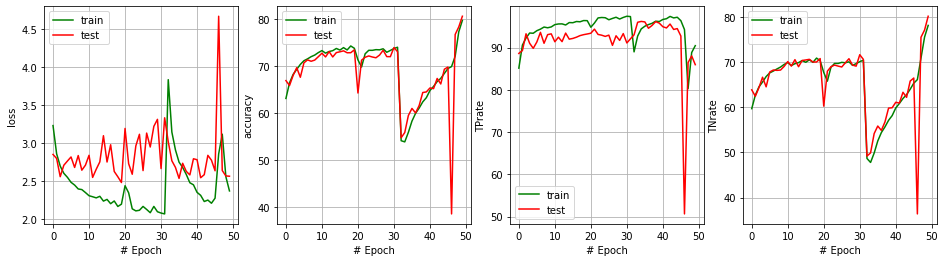

In [88]:
# --- Display loss and accuracy for train and test set
my_score = tools_score.Score(do_class_method)
my_score.plot_curve(score_train_l, score_test_l)

# Display results as tag-o-gram

Now that our model has been trained we will use it to create a tag-o-gram (tag likelihood over the patches of an audio file).

In [90]:
def F_tag_o_gram(audio_file):
    """
    """
    if do_student:
        # --- START CODE HERE
        data_m, time_sec_v = F_get_audio_features(audio_file)
        nb_frame = data_m.shape[1]

        middle_frame = patch_halfduration_frame
        patches_test_l = []  # list of all patches
        while middle_frame + patch_halfduration_frame < nb_frame:
          start_frame = middle_frame - patch_halfduration_frame
          stop_frame = middle_frame + patch_halfduration_frame
          current_patch = data_m[:, start_frame:stop_frame]
          patches_test_l.append(current_patch)
          middle_frame += patch_hop_frame

        batch = len(patches_test_l)
        n_row, n_col = patches_test_l[0].shape
        to_test  = np.zeros((batch, n_row, n_col))
        for i in range(batch):
          to_test[i] = patches_test_l[i]

        to_test = torch.from_numpy(to_test).float().cuda()
        to_test = to_test[:,None,:,:]
        
        with torch.no_grad():
            model.eval()
            y_hat_m = model(to_test)
        y_hat_m = y_hat_m.detach().cpu().numpy()                                   


        # --- STOP CODE HERE

    fig, axes = plt.subplots(1, 1, figsize=(16, 6))
    im = axes.imshow(y_hat_m.T, aspect='auto', cmap=plt.get_cmap('inferno'))
    axes.set_yticks(np.arange(0,len(test_set.labelname_dict_l)))
    axes.set_yticklabels(test_set.labelname_dict_l)
    axes.grid(True)
    fig.colorbar(im, orientation='vertical')

    return

### Test

We now test our tag-o-gram on an audio file.
You should get the following output.

```
{'album': 'CD2 The Sowebo Concert',
 'artist': 'Jay Kishor',
 'clip_id': 3649,
 'mp3_path': 'c/jay_kishor-cd2_the_sowebo_concert-01-raga_malkauns-146-175.mp3',
 'original_url': 'http://he3.magnatune.com/all/01-Raga%20Malkauns-Jay%20Kishor.mp3',
 'segmentEnd': 175,
 'segmentStart': 146,
 'tag': ['guitar', 'quiet', 'india'],
 'target': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'title': 'Raga Malkauns',
 'track_number': 1,
 'url': 'http://www.magnatune.com/artists/albums/kishor-sowebo2/'}
 ````

<img src="https://perso.telecom-paristech.fr/gpeeters/doc/Lab_DL_MagnaTagATune_05.png">

As you see, while the track has been tagged 'guitar', it actually contains a [sitar](https://en.wikipedia.org/wiki/Sitar); which has been correctly detected by our trained model.

628
(628,)
{'album': 'CD2 The Sowebo Concert',
 'artist': 'Jay Kishor',
 'clip_id': 3649,
 'mp3_path': 'c/jay_kishor-cd2_the_sowebo_concert-01-raga_malkauns-146-175.mp3',
 'original_url': 'http://he3.magnatune.com/all/01-Raga%20Malkauns-Jay%20Kishor.mp3',
 'segmentEnd': 175,
 'segmentStart': 146,
 'tag': ['guitar', 'quiet', 'india'],
 'target': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'title': 'Raga Malkauns',
 'track_number': 1,
 'url': 'http://www.magnatune.com/artists/albums/kishor-sowebo2/'}


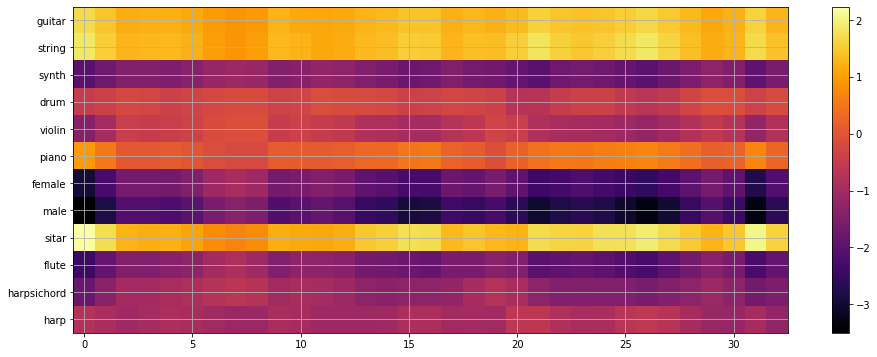

In [91]:
idx_file = 902
test_file = DIR + dataset_subDIR + dataset_l[idx_file]['mp3_path']
F_tag_o_gram(audio_file = test_file)
pp.pprint(dataset_l[idx_file])
IPython.display.Audio(test_file)

We can observe that our model can detect the main instrument is guitar and string. It also found sitar in the song.

628
(628,)
{'album': 'Rameau and Leclair',
 'artist': 'Philharmonia Baroque',
 'clip_id': 3158,
 'mp3_path': '6/philharmonia_baroque-rameau_and_leclair-01-overture_tres_vite__menuet_lent__air_gay_rameau_les_paladins-117-146.mp3',
 'original_url': 'http://he3.magnatune.com/all/01-Overture%20tres%20vite%20_%20Menuet%20lent%20_%20Air%20gay%20(Rameau_%20Les%20Paladins)-Philharmonia%20Baroque.mp3',
 'segmentEnd': 146,
 'segmentStart': 117,
 'tag': ['classical',
         'string',
         'no singer',
         'violin',
         'orchestra',
         'orchestra'],
 'target': array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 'title': 'Overture tres vite _ Menuet lent _ Air gay (Rameau_ Les Paladins)',
 'track_number': 1,
 'url': 'http://www.magnatune.com/artists/albums/pb-rameau-leclair/'}


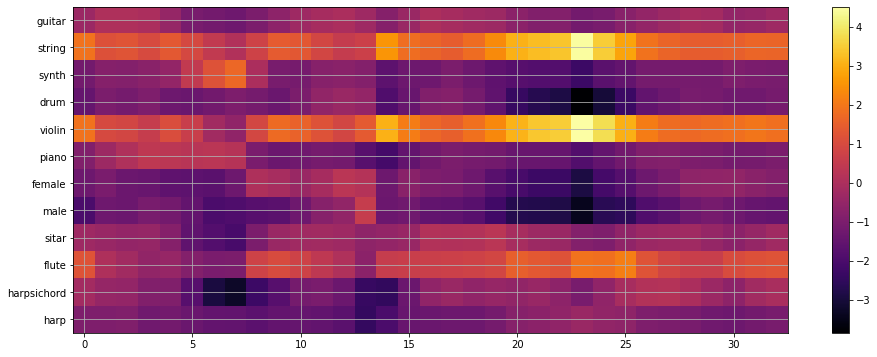

In [94]:
idx_file = 800
test_file = DIR + dataset_subDIR + dataset_l[idx_file]['mp3_path']
F_tag_o_gram(audio_file = test_file)
pp.pprint(dataset_l[idx_file])
IPython.display.Audio(test_file)

Algorithm can detect violin and string in the song.

628
(628,)
{'album': 'Ludwig Senfl',
 'artist': 'Farallon Recorder Quartet',
 'clip_id': 1736,
 'mp3_path': '6/farallon_recorder_quartet-ludwig_senfl-01-gesellschaft_ist_gut-0-29.mp3',
 'original_url': 'http://he3.magnatune.com/all/01-Gesellschaft%20ist%20gut-Farallon%20Recorder%20Quartet.mp3',
 'segmentEnd': 29,
 'segmentStart': 0,
 'tag': ['quiet', 'classical', 'quiet', 'flute', 'flute'],
 'target': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 'title': 'Gesellschaft ist gut',
 'track_number': 1,
 'url': 'http://www.magnatune.com/artists/albums/farallon-senfl/'}


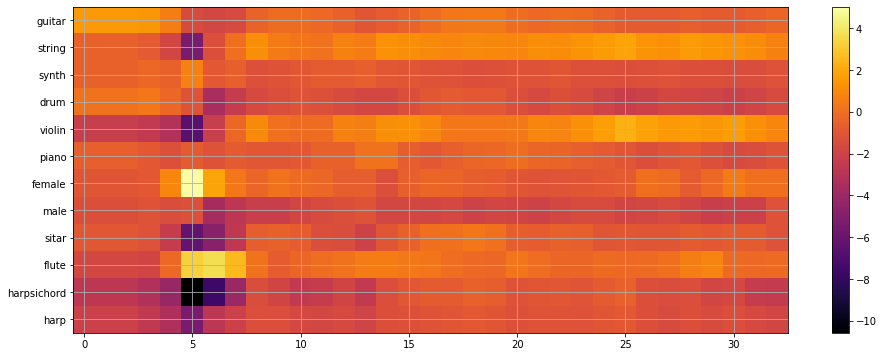

In [99]:
idx_file = 410
test_file = DIR + dataset_subDIR + dataset_l[idx_file]['mp3_path']
F_tag_o_gram(audio_file = test_file)
pp.pprint(dataset_l[idx_file])
IPython.display.Audio(test_file)

In this song, it seems detect flute and female in some patchs when the sound began (There is a muted duration at the beginning). Algorithm resulted not well with this sample.